# EnKF Experiments - GCS

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

## Data paths

In [6]:
data_dir = '../results/data/exp1/'
model_dir = '../results/models/exp1/'
fig_dir = '../results/figures/exp1/'

## Experiment 1 - Setting Up EnKF

### Base model inclusion in error calculations

In [7]:
# Modeller.run_experiment_1(pop_size=20, inclusion=AgentIncluder.BASE)

In [8]:
Processor.process_experiment_1()

#### Read data

In [20]:
results = pd.read_csv(data_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,baseline
0,0,NaN,NaN,NaN,NaN
1,20,48.577215,1.000997,0.704886,38.524231
2,40,7.899885,1.932897,0.871831,29.316199
3,60,8.736288,1.108110,1.621981,24.605872
4,80,11.653986,1.510926,1.042770,31.004966


In [21]:
results.shape

(2148, 5)

#### Tidy up data

In [22]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [23]:
tidy_df = tidy_dataframe(results, 'time', error_types)
tidy_df.head()

,time,variable,value
0,0.0,forecast,NaN
1,0.0,obs,NaN
2,0.0,analysis,NaN
3,0.0,baseline,NaN
4,20.0,forecast,48.577215


#### Plot results - mean

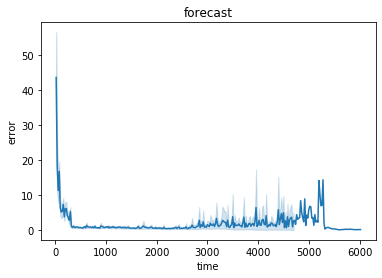

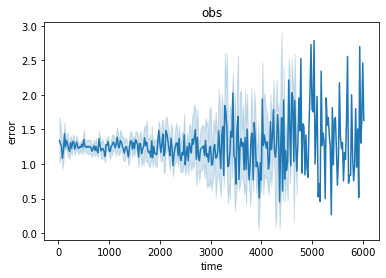

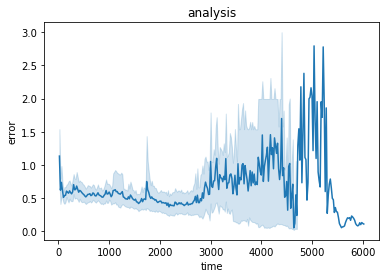

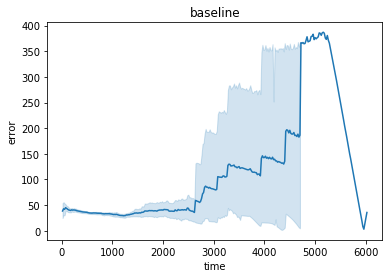

In [30]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_1_BASE_mean_{error_type}.pdf')
    plt.show()

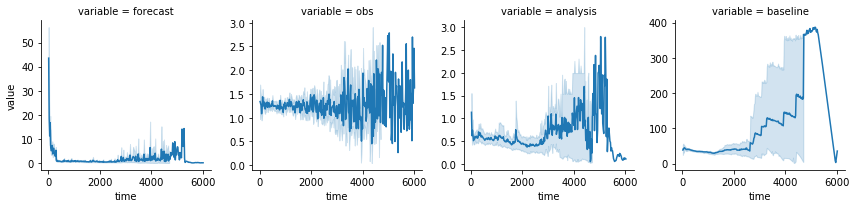

In [31]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value')

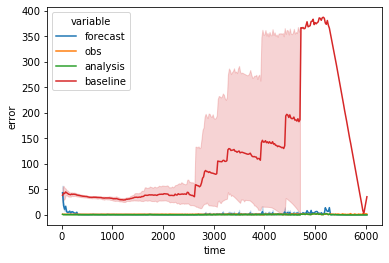

In [32]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_BASE_mean.pdf')
plt.show()

In [33]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

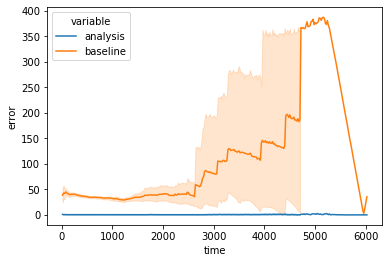

In [34]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_BASE_mean_reduced.pdf')
plt.show()

#### Plot results - median

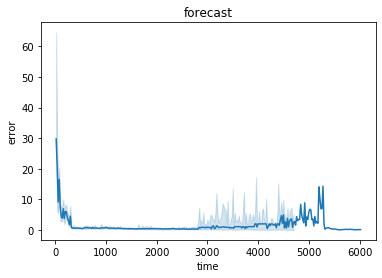

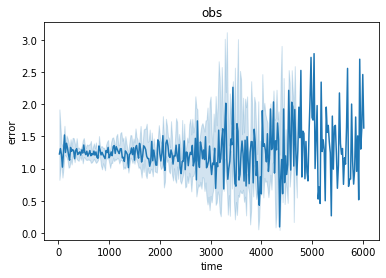

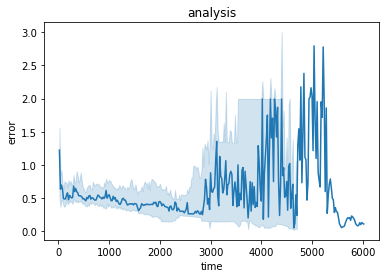

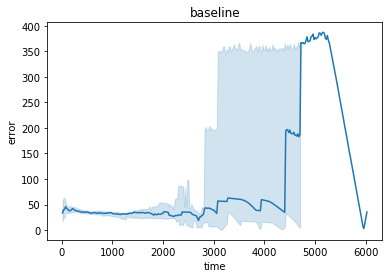

In [35]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, estimator=np.median)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_1_BASE_median_{error_type}.pdf')
    plt.show()

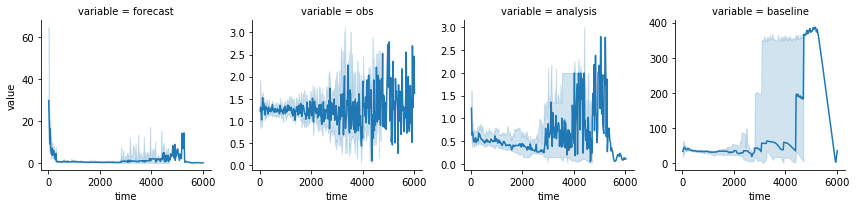

In [36]:
g = sns.FacetGrid(tidy_df, col='variable', sharey=False)
g.map(sns.lineplot, 'time', 'value', estimator=np.median)

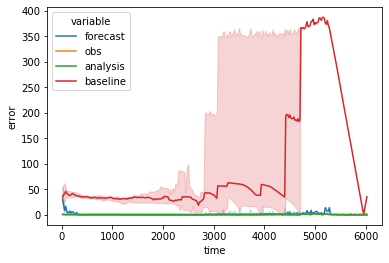

In [37]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_BASE_median.pdf')
plt.show()

In [38]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

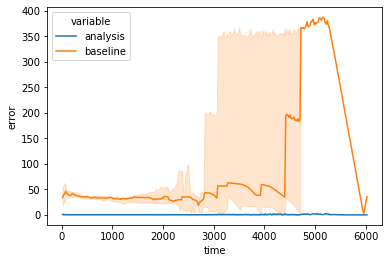

In [39]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_BASE_median_reduced.pdf')
plt.show()

### Ensemble mode inclusion in error calculations

In [38]:
# Modeller.run_experiment_1(pop_size=20, inclusion=AgentIncluder.MODE_EN)

In [39]:
Processor.process_experiment_1()

#### Read data

In [40]:
results = pd.read_csv(gcs_model_1_dir + 'p20/metrics.csv')
results.head()

,time,forecast,obs,analysis,baseline
0,0,NaN,NaN,NaN,NaN
1,20,41.839655,2.512491,2.205533,42.018758
2,40,15.265979,1.533514,0.711656,34.075678
3,60,4.282254,1.420262,0.596379,34.369666
4,80,26.582844,1.426647,0.574911,45.581546


In [41]:
results.shape

(2050, 5)

#### Tidy up data

In [42]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [43]:
tidy_df = tidy_dataframe(results, 'time', error_types)
tidy_df.head()

,time,variable,value
0,0.0,forecast,NaN
1,0.0,obs,NaN
2,0.0,analysis,NaN
3,0.0,baseline,NaN
4,20.0,forecast,41.839655


#### Plot results - mean

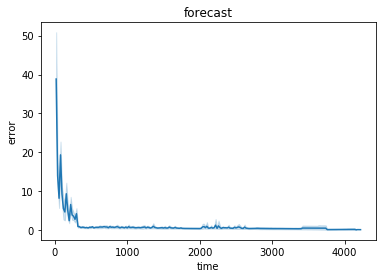

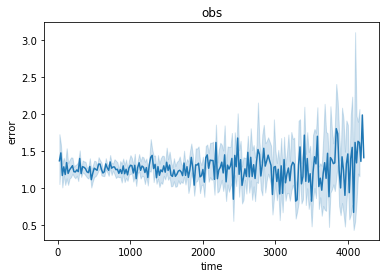

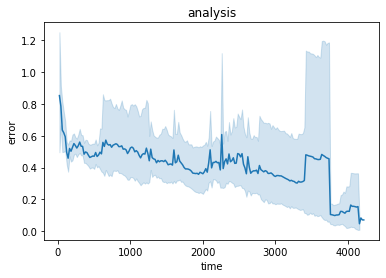

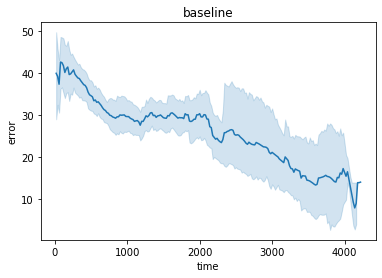

In [44]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_1_MODE_EN_mean_{error_type}.pdf')
    plt.show()

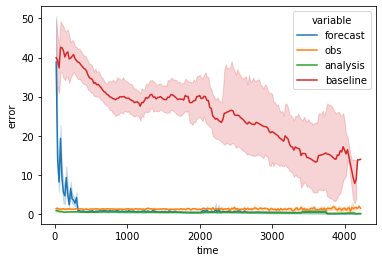

In [45]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_MODE_EN_mean.pdf')
plt.show()

In [46]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

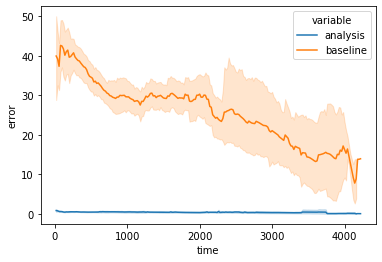

In [47]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_MODE_EN_mean_reduced.pdf')
plt.show()

#### Plot results - median

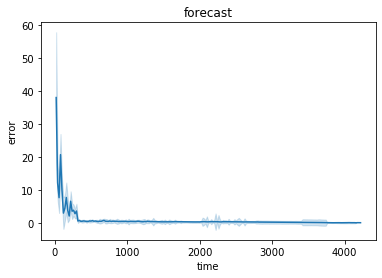

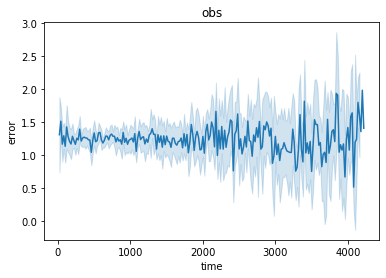

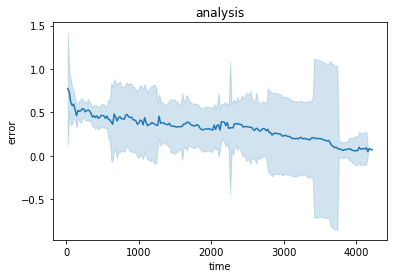

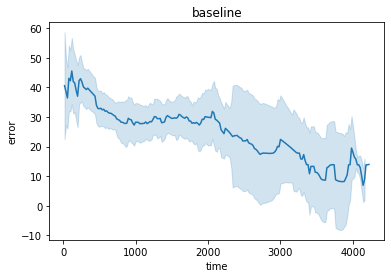

In [48]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df, ci='sd', estimator=np.median)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_1_MODE_EN_median_{error_type}.pdf')
    plt.show()

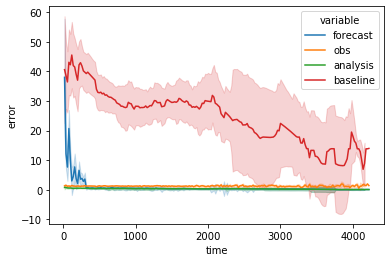

In [49]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df, ci='sd', estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_MODE_EN_median.pdf')
plt.show()

In [50]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

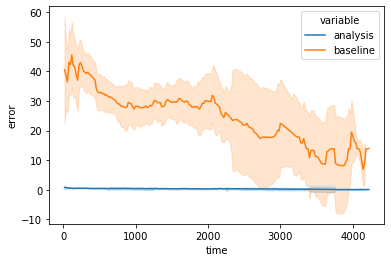

In [51]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df, ci='sd', estimator=np.median)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_MODE_EN_median_reduced.pdf')
plt.show()